### Data generator

For selected font, script will generate each of above character (a-z, A-Z, 0-9) at nine different position to move text by one pixel in right-left and top-bottom direction. 

#### NOTE: If you want generate some new data use kernel == python2, because ttfquery can cause problems at python3
Also you can use generated images from Synthetic_dataset

#### Imports

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import ttfquery.findsystem 
import string
import ntpath
import numpy as np
import os
import glob

### Generator

Input params:

    fontSize
    imgSize
    position
    font_list - list of fonts which will be used

In [ ]:
#parameters of font and picture
fontSize = 20
imgSize = (28,28)
position = (0,0)

#fonts which will be used
fonts_list = ['Arial', 'Verdana', 'Comic_Sans_MS', 'Courier_New', 'Times_New_Roman', 'Impact', 'Georgia', 'Trebuc', \
             'Andalemo', 'Lato-Regular']
fonts_list.sort()
total_fonts = len(fonts_list)

#all images will be stored in 'Synthetic_dataset' directory under current directory
dataset_path = os.path.join (os.getcwd(), 'Synthetic_dataset')
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)

#creating character list
#it can contains lower case chars, upper case chars and digits
fhandle = open('Fonts_list.txt', 'r')
lower_case_list = list(string.ascii_lowercase)
upper_case_list = list(string.ascii_uppercase)
digits = range(0,10)
digits_list=[str(i) for i in digits]
all_char_list = lower_case_list + upper_case_list + digits_list

#path to ubuntu fonts
#all_fonts = glob.glob("/usr/share/fonts/truetype/msttcorefonts/*.ttf")
all_fonts = ttfquery.findsystem.findFonts()
f_flag = np.zeros(total_fonts)

for sys_font in all_fonts:
    font_file = ntpath.basename(sys_font)
    font_file = font_file.rsplit('.')
    font_file = font_file[0]
    f_idx = 0
    for font in fonts_list: #use fonts from list
        f_lower = font.lower()
        s_lower = sys_font.lower()
        #check desired font 
        #use only regular style
        if f_lower in s_lower and 'bold' not in s_lower and 'italic' not in s_lower:
            #if commented, data will contain all styles of each font
            fonts_list.remove(font)
            path = sys_font
            font = ImageFont.truetype(path, fontSize)
            f_flag[f_idx] = 1
            for ch in all_char_list:
                image = Image.new("RGB", imgSize, (255,255,255))
                draw = ImageDraw.Draw(image)
                pos_x = 0
                pos_y = 0
                pos_idx=0
                for y in [pos_y-1, pos_y, pos_y+1]:
                    for x in [pos_x-1, pos_x, pos_x+1]:
                        position = (x,y)
                        draw.text(position, ch, (0,0,0), font=font)
                        ##without this flag, it creates 'Calibri_a.jpg' even for 'Calibri_A.jpg'
                        ##which overwrites lowercase images
                        l_u_d_flag = "u"
                        if ch.islower():
                            l_u_d_flag = "l"
                        elif ch.isdigit():
                            l_u_d_flag = "d"
                        file_name = str(pos_idx) + '_' + font_file + '_' + l_u_d_flag + '_' + ch + '.jpg'
                        file_name = os.path.join(dataset_path,file_name)
                        image.save(file_name)
                        pos_idx = pos_idx + 1
        f_idx = f_idx + 1

### Data preparation

Here python3 is recommended

#### Imports

In [1]:
import numpy as np
import keras
import tensorflow as tf
import os
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization 
from keras.layers import Conv2D, MaxPooling1D, ActivityRegularization, MaxPooling2D
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### Read data

In [2]:
fonts_list = ['Arial', 'Verdana', 'Comic_Sans_MS', 'Courier_New', 'Times_New_Roman', 'Impact', 'Georgia', 'Trebuc', \
             'Andalemo', 'Lato-Regular']
fonts_list.sort()

dirName = './Synthetic_dataset/'
pics = os.listdir(dirName)
imgGen = ImageDataGenerator()
fullnames = []
xnames = []

def data_read(postion='0'):
    """
    position is pixel from char starts
    """
    y = []
    X = []
    for name in pics:
        if name[0] == postion: # for only 1 usage of each font with "0" position
            for i in range(len(fonts_list)):
                #creating labels for fonts
                font_i_lower = fonts_list[i].lower()
                name_lower = name.lower()
                if font_i_lower in name_lower:
                    y_cur = i
                    y.append(y_cur)
                    fullname = os.path.join(dirName,name)
                    if os.path.isfile(fullname):
                        fullnames.append(fullname)
                    #loading picture and converting to array
                    img = load_img(fullname, color_mode='grayscale')
                    #imgGen.standardize(img)
                    x = img_to_array(img)
                    X.append(x)
                    xnames.append(name)

    y = np.asarray(y)
    X = np.asarray(X)
    
    return X, y
X, y = data_read(postion='0')

#### Split data to train, validation and test
    Train data is 70% of images
    Validation data is 15% 
    Test data is 15%
    
Also, its not necessary to create validation set, keras can create it from train data, but here it was done

In [3]:
y_oh = keras.utils.to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_oh, test_size=0.3, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, shuffle=True)
print('train_shape', X_train.shape, '\nval_shape', X_val.shape, '\ntest_shape', X_test.shape)

train_shape (434, 28, 28, 1) 
val_shape (93, 28, 28, 1) 
test_shape (93, 28, 28, 1)


### Model creating

In [4]:
def create_model(params):
    """
    params -- dict of hyperparamets which will be tuned
    """
    model = Sequential()
    model.add(Conv2D(params['conv_filt'], (3, 3), activation='sigmoid', input_shape=IMG_SIZE))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(params['dropout_1']))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(params['dense_units'], activation='sigmoid', kernel_initializer='uniform'))
    model.add(Dropout(params['dropout_2']))
    model.add(ActivityRegularization(l2=params['l2_coef']))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    
    return model

### Datagen for train and valdation

In [73]:
def datagen(model, batch_size=16, epochs=10, verbose=1, nb_train_samples = 2000, nb_validation_samples = 800):
    """
    creating train/validaton generators for model fitting
    """
    # this is the augmentation configuration we will use for training
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=False)

    # this is the augmentation configuration we will use for testing:
    # only rescaling
    test_datagen = ImageDataGenerator(rescale=1. / 255,)

    train_generator = train_datagen.flow(
        x=X_train,
        y=y_train,
        batch_size=batch_size)

    validation_generator = test_datagen.flow(
        x=X_val,
        y=y_val,
        batch_size=batch_size)

    history = model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size,
        verbose=verbose,
        workers=1, #if you want multiprocessing change it
        use_multiprocessing=False,)
    
    return history

## Tuning hyperparameters
#### First iteration
The aim of this iteration is reduce parameters bounds

Parameters which will be tuned

In [99]:
batch_sizes = [10,16,32] #grid search
epochs = 50
# conv filters and dense units will be randomly generated in [filt_lb,filt_rb] and [unit_lb,unit_lb]
filt_b = [4, 128]
unit_b = [8, 36]
IMG_SIZE = X.shape[1:]
# dropout random gen in [0,1]
drop_1_b = [0,1]
drop_2_b = [0,1]
#for random l2 ceoff in [1e-2,1e-4]
a = np.log10(1e-4)
b = np.log10(1e-1)

num_experiments = 20 #for each batch

### Tuning process

In [103]:
np.random.seed(42) 
res = []
weights = []
beta = 2
for batch in batch_sizes:
    for num in range(num_experiments):
        print(num)    
        params = dict(conv_filt=np.random.randint(filt_b[0], filt_b[1]), \
                      dropout_1=(drop_1_b[1]-drop_1_b[0])*np.random.rand()+drop_1_b[0],\
                      dense_units=np.random.randint(unit_b[0], unit_b[1]),\
                      dropout_2=(drop_2_b[1]-drop_2_b[0])*np.random.rand()+drop_2_b[0],\
                      l2_coef=10**((b-a)*np.random.rand()+a))
        print(params)
        model = create_model(params)
        history = datagen(model, batch_size=batch, epochs=epochs, verbose=0, nb_train_samples=4000, nb_validation_samples=800)
        score = model.evaluate(X_test/255., y_test, batch_size=batch)
        params['batch']=batch
        params['score']=score
        params['score_train']=[history.history['loss'][-1], history.history['acc'][-1]]
        params['f1_score'] = (1.+beta**2) * (score[1] * history.history['acc'][-1])/(beta**2*score[1] + \
                                                                                     history.history['acc'][-1])
        res.append(params)
        print('train score', params['score_train'], 'test score', score)         

0
{'conv_filt': 106, 'dropout_1': 0.7965429868602328, 'dense_units': 22, 'dropout_2': 0.7319939418114051, 'l2_coef': 0.0062513735745217472}
93/93 [==============================] - 0s 1ms/step
train score [2.2427217483037145, 0.17435377975571778] test score [2.0737653586172287, 0.26881720942835652]
1
{'conv_filt': 48, 'dropout_1': 0.5925732959280999, 'dense_units': 34, 'dropout_2': 0.30936663580329316, 'l2_coef': 0.0027536734491045026}
93/93 [==============================] - 0s 1ms/step
train score [0.58986672831560472, 0.85554991809776815] test score [0.84643531879109724, 0.7741935522325577]
2
{'conv_filt': 93, 'dropout_1': 0.9205962353601225, 'dense_units': 20, 'dropout_2': 0.8489032155838712, 'l2_coef': 0.022064734684880266}
93/93 [==============================] - 0s 1ms/step
train score [2.2990746876339108, 0.11099848170088319] test score [2.321241263420351, 0.09677419499043495]
3
{'conv_filt': 102, 'dropout_1': 0.6765268096263608, 'dense_units': 32, 'dropout_2': 0.09473870481205

93/93 [==============================] - 0s 847us/step
train score [0.41606745275894297, 0.90397521941146097] test score [1.014718928644734, 0.70967742127756916]
8
{'conv_filt': 86, 'dropout_1': 0.2334498951610443, 'dense_units': 34, 'dropout_2': 0.3118982317634911, 'l2_coef': 0.0028123638066972103}
93/93 [==============================] - 0s 825us/step
train score [0.74231614598838025, 0.82447083118224063] test score [0.84089558483451921, 0.77419355030982728]
9
{'conv_filt': 103, 'dropout_1': 0.5441965951687223, 'dense_units': 16, 'dropout_2': 0.1820169365195693, 'l2_coef': 0.036623067803837318}
93/93 [==============================] - 0s 901us/step
train score [2.2988642853563079, 0.11228704181724317] test score [2.3203684232568227, 0.09677419394895595]
10
{'conv_filt': 17, 'dropout_1': 0.28333456844309346, 'dense_units': 8, 'dropout_2': 0.5998422716035572, 'l2_coef': 0.013289011850598652}
93/93 [==============================] - 0s 858us/step
train score [1.6550479937165929, 0.40965

93/93 [==============================] - 0s 504us/step
train score [2.2991427482866911, 0.11073825519895455] test score [2.3214244842529297, 0.096774193388159555]
15
{'conv_filt': 66, 'dropout_1': 0.3382902217418693, 'dense_units': 27, 'dropout_2': 0.9848491149402895, 'l2_coef': 0.0016461604455988155}
93/93 [==============================] - 0s 536us/step
train score [2.2986624905542423, 0.10918946829218193] test score [2.3213479544526789, 0.096774193388159555]
16
{'conv_filt': 58, 'dropout_1': 0.33397401364231694, 'dense_units': 10, 'dropout_2': 0.8034642485993253, 'l2_coef': 0.0012969706759797018}
93/93 [==============================] - 0s 557us/step
train score [2.2991951259067518, 0.10970573061880035] test score [2.3215769516524447, 0.096774193388159555]
17
{'conv_filt': 41, 'dropout_1': 0.4305528017301362, 'dense_units': 31, 'dropout_2': 0.6722635672180086, 'l2_coef': 0.011576802304063627}
93/93 [==============================] - 0s 547us/step
train score [2.2989770019552913, 0.1

#### Second iteration

### Select top N models and do new tuning

Choose N top models for parameters bounds reducing

### How top models will be selected

Because all processes is automatic we will check 
$ F_\beta = (1+\beta^2) * \frac{accuracy_{test} * \frac{accuracy_{test}}{accuracy_{train}}}{\beta^2 * accuracy_{test} + \frac{accuracy_{test}}{accuracy_{train}}}, $
where $ \beta = 2, $
beacuse we preffer $accuracy_{test}$

It provides us to select high test accuracy and non overfitted model

In [ ]:
N = 3 
scorelist = [res_i['f1_score'] for res_i in res]
scorelist_sorted = sorted(scorelist, reverse=True)
toplist_ind = [scorelist.index(scorelist_sorted[i]) for i in range(N)]
toplist = [res[i] for i in toplist_ind]
params_full = dict(conv_filt=[], dropout_1=[], dense_units=[],\
                    dropout_2=[], l2_coef=[], batch=[], score=[])
for key in params_full.keys():
    for i in range(N):
        params_full[key].append(toplist[i][key])
print(params_full)        
#creating new params bounds
filt_b = [np.min(params_full['conv_filt']), np.max(params_full['conv_filt'])]
unit_b = [np.min(params_full['dense_units']), np.max(params_full['dense_units'])]
drop_1_b = [np.min(params_full['dropout_1']), np.max(params_full['dropout_1'])]
drop_2_b = [np.min(params_full['dropout_2']), np.max(params_full['dropout_2'])]
batch_sizes = np.unique(params_full['batch'])
print(batch_sizes)
file = open('history.txt', mode='a') #here will be model history
#run tunning
num_experiments = 30 #for each batch
res = []
weights = []
best_f1_score = 0.0
beta = 2
for batch in batch_sizes:
    for num in range(num_experiments):
        print(num)    
        params_top = dict(conv_filt=np.random.randint(filt_b[0], filt_b[1]), \
                          dropout_1=(drop_1_b[1]-drop_1_b[0])*np.random.rand()+drop_1_b[0],\
                          dense_units=np.random.randint(unit_b[0], unit_b[1]),\
                          dropout_2=(drop_2_b[1]-drop_2_b[0])*np.random.rand()+drop_2_b[0],\
                          l2_coef=10**((b-a)*np.random.rand()+a))
        model = create_model(params_top)
        history = datagen(model, batch_size=batch, epochs=epochs, verbose=0)
        score = model.evaluate(X_test/255., y_test, batch_size=batch)
        params_top['batch']=batch
        params_top['score']=score
        params_top['f1_score'] = (1.+beta**2) * (score[1] * history.history['acc'][-1])/(beta**2*score[1] + \
                                                                                     history.history['acc'][-1])
        if params_top['f1_score'] > best_f1_score:
            best_f1_score = params_top['f1_score']
            np.savetxt('acc.txt', history.history['acc'])
            np.savetxt('loss.txt', history.history['loss'])
            np.savetxt('val_acc.txt', history.history['val_acc'])
            np.savetxt('val_loss.txt', history.history['val_loss'])
            model.save('model_topN_'+str(batch)+'_'+str(num))
            print('cur_best_score = ', score, ' cur_best_f1_score = ', best_f1_score)
        res.append(params_top)
        print('test score', score)
        

{'conv_filt': [96, 74, 69], 'dropout_1': [0.6435756803482191, 0.37539457718168873, 0.47459860563811973], 'dense_units': [31, 32, 28], 'dropout_2': [0.14375970509764996, 0.1077160546046062, 0.082768131879926488], 'l2_coef': [0.00022329032842384659, 0.0033534822653007905, 0.0016625590975724775], 'batch': [10, 10, 10], 'score': [[0.54213241984446847, 0.86021504607251897], [0.85507870858074519, 0.80645161162140544], [0.85693052699488981, 0.77419354902800697]]}
[10]
0


### Load history for visualization

In [105]:
hist = {'acc': np.loadtxt('acc.txt'), 'loss':np.loadtxt('loss.txt'), 'val_acc': np.loadtxt('val_acc.txt'), \
        'val_loss':np.loadtxt('val_loss.txt')}
history = hist

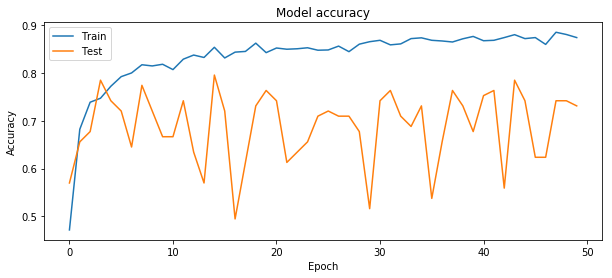

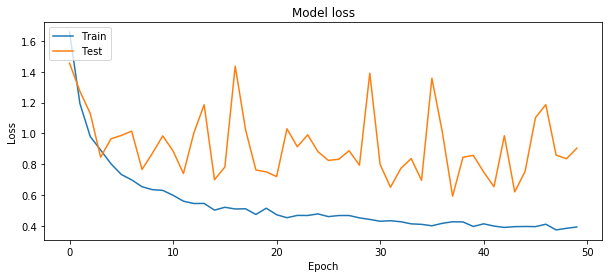

In [106]:
# Plot training & validation accuracy values
plt.figure(figsize=(10,4))
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10,4))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
